In [1]:
import warnings
from datetime import date
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

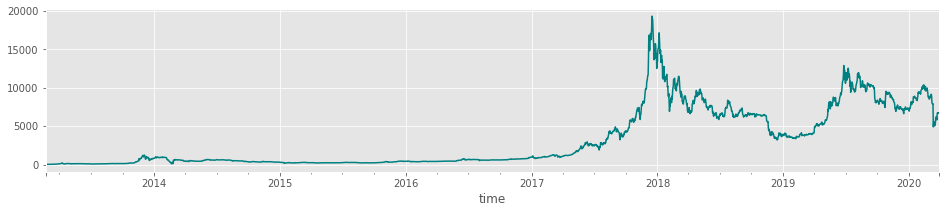

In [2]:
# Load data

data = pd.read_csv("BTC_processed.csv")
data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time', drop = True)
data = data[~data.index.duplicated(keep='first')]

# log price
data_price = data['close']
data_price.head()
data_price.plot(y='close', color='teal', figsize=(16,3))

In [3]:
data_price_log = np.log(data_price)
data_price_log_diff = data_price_log.diff().dropna()

# ARMA(3,5)
p, q = 3, 5
aic, bic = [], []

# Constant training window, you can change it to match your LSTM
train_size = int(len(data_price_log_diff) * 0.7 )
y_true = data_price_log_diff.iloc[train_size:]

# not important
convergence_error = stationarity_error = 0


y_pred = []
for T in range(train_size, len(data_price_log_diff)):
    train_set = data_price_log_diff.iloc[T-train_size:T]
    try:
        model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
        forecast, _, _ = model.forecast(steps=1)
        y_pred.append(forecast[0])
        aic.append(model.aic)
        bic.append(model.bic)

    # not important
    except LinAlgError:
        convergence_error += 1
        y_pred.append(np.nan)
        aic.append(np.nan)
        bic.append(np.nan)
    except ValueError:
        stationarity_error += 1
        y_pred.append(np.nan)
        aic.append(np.nan)
        bic.append(np.nan)
    



In [5]:
result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
          .replace(np.inf, np.nan)
          .ffill(0).dropna())

rmse = np.sqrt(mean_squared_error(
    y_true=result.y_true, y_pred=result.y_pred))

In [10]:
result.to_pickle("result_ARMA35_1day.pk")

In [ ]:
# pd.read_pickle("result_ARMA35_1day.pk")

In [9]:
result[:50]

,y_true,y_pred
time,,
2018-03-04,0.003401,0.000047
2018-03-05,-0.005552,0.000047
2018-03-06,-0.063628,0.000047
2018-03-07,-0.078136,0.000047
2018-03-08,-0.063605,0.000047
2018-03-09,-0.006889,0.000047
2018-03-10,-0.050480,0.000047
2018-03-11,0.081559,0.000047
2018-03-12,-0.043105,0.000047


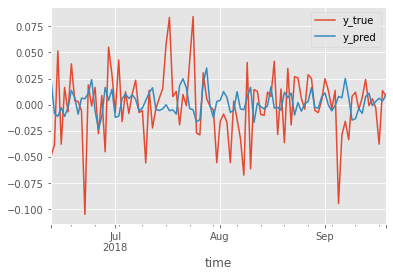

In [7]:
result[100:200].plot()